<a href="https://colab.research.google.com/github/linhkid/GDG-DevFest-Codelab-24/blob/main/solutions/02-a-FGSM-Adversarial-Attack_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Gradient Sign Method (FGSM) Adversarial Attack Workshop

## Introduction to Adversarial Attacks
In this workshop, we'll explore how to create adversarial examples using the Fast Gradient Sign Method (FGSM). These examples are carefully crafted perturbations that can cause a deep learning model to misclassify images, despite the changes being nearly imperceptible to human eyes.

### What are Adversarial Attacks?

Adversarial attacks are techniques used to fool machine learning models by making small, carefully crafted changes to the input data. These changes are designed to exploit the model's vulnerabilities and cause it to make incorrect predictions.

![Adversarial Attacks](https://github.com/linhkid/GDG-DevFest-Codelab-24/blob/main/img/advers1.png?raw=1)

### How do Adversarial Attacks Work?

Adversarial attacks work by computing the gradient of the loss function with respect to the input data. This gradient provides information about how the model's prediction would change if the input data were modified slightly. By following the direction of the gradient, we can generate perturbations that cause the model to make incorrect predictions.

### Fast Gradient Sign Method (FGSM)

The Fast Gradient Sign Method (FGSM) is a simple but effective technique for generating adversarial examples. It works by taking the sign of the gradient of the loss function with respect to the input data and using it to perturb the input data in the direction that maximizes the loss. This results in an adversarial example that causes the model to make incorrect predictions.

![Adversarial Attacks](https://github.com/linhkid/GDG-DevFest-Codelab-24/blob/main/img/advers2.png?raw=1)

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.






## Learning objectives
After completing this workshop, you'll be able to:

- Create adversarial examples using the Fast Gradient Sign Method (FGSM)
- Understand the concepts behind adversarial attacks
- Implement the FGSM attack

## Approach

- Input Processing: Start with a pre-trained MobileNetV2 model and a test image (Labrador)
- Gradient Computation: Calculate the loss gradient with respect to the input image
- Perturbation Generation: Use the sign of these gradients to create small perturbations
- Adversarial Example Creation: Apply scaled perturbations to create adversarial images
- Evaluation: Compare model predictions on original vs adversarial images


## Key Terms

- Fast Gradient Sign Method (FGSM): A method for creating adversarial examples by perturbing the input image in the direction of the gradient of the loss function with respect to the input image.
- Adversarial attacks: A technique for creating adversarial examples that can be used to fool machine learning models

## Application
Detecting vulnerabilities and misjudgments in systems:

- Facial recognition
- Sign recognition
- Self-driving cars
- etc.


### Install and Import Dependencies
Run this cell to install and import all required libraries

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


### Load Pre-trained Model

In [ ]:
# Load pre-trained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

14536120/14536120 [==============================] - 0s 0us/step


## Helper functions

In [ ]:
# Helper function to preprocess images
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels
def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

In [ ]:
# Helper function to display image
def display_image_pair(image1, image2, title1, title2, show_confidence=True, figsize=(12, 5)):
    """
    Display two images side by side with titles and optionally predictions.

    Args:
        image1, image2: Input image tensors
        title1, title2: Base titles for the images
        show_confidence: Whether to show model predictions and confidence
        figsize: Figure size tuple (width, height)
    """
    plt.figure(figsize=figsize)

    # Display first image
    plt.subplot(1, 2, 1)
    display_img1 = image1[0] * 0.5 + 0.5
    plt.imshow(display_img1)
    if show_confidence:
        _, label1, confidence1 = get_imagenet_label(pretrained_model.predict(image1))
        full_title1 = f'{title1}\n{label1} : {confidence1:.2%}'
    else:
        full_title1 = title1
    plt.title(full_title1)
    plt.axis('off')

    # Display second image
    plt.subplot(1, 2, 2)
    display_img2 = image2[0] * 0.5 + 0.5
    plt.imshow(display_img2)
    if show_confidence:
        _, label2, confidence2 = get_imagenet_label(pretrained_model.predict(image2))
        full_title2 = f'{title2}\n{label2} : {confidence2:.2%}'
    else:
        full_title2 = title2
    plt.title(full_title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and prepare image

1/1 [==============================] - 1s 694ms/step


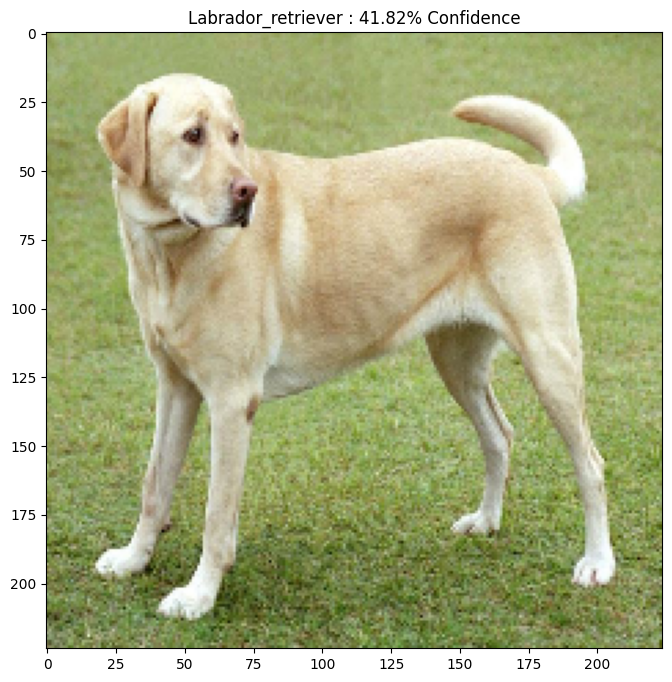

In [ ]:
# Download sample image
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# Preprocess image
image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Display original image
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## FGSM Attack Implementation

In [ ]:
# Create loss object for calculating the gradient of the loss with respect to the input image
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
   """
   Creates the adversarial pattern that will be used to perturb the input image.

   Args:
       input_image: The original input image tensor
       input_label: The target label to maximize loss against

   Returns:
       The signed gradients that form the adversarial pattern
   """
   # Use GradientTape to track operations for automatic differentiation
   with tf.GradientTape() as tape:
       # Tell tape to watch the input image tensor
       tape.watch(input_image)

       # TODO: Get model prediction on input image
       # HINT: Use the pretrained_model to get predictions
       prediction = pretrained_model(input_image)

       loss = loss_object(input_label, prediction)

   # TODO: Get the gradients of the loss with respect to the input image
   # HINT: Use tape.gradient() with loss and input_image as arguments
   gradient = tape.gradient(loss, input_image)

   # TODO: Get the sign of the gradients to create the perturbation
   # HINT: Use tf.sign() on the gradient
   signed_grad = tf.sign(gradient)

   return signed_grad

def generate_adversarial_examples(original_image, target_class, epsilons):
   """
   Generate and display adversarial examples with different epsilon values.

   The function follows these steps:
   1. Creates one-hot encoded target label
   2. Generates the adversarial perturbation pattern
   3. Creates adversarial examples by adding scaled perturbations
   4. Displays the original vs adversarial images

   Args:
       original_image: Input image tensor to be perturbed
       target_class: Index of the target class to fool the model into predicting
       epsilons: List of perturbation scales to try
   """
   # Create one-hot encoded target label
   label = tf.one_hot(target_class, image_probs.shape[-1])
   label = tf.reshape(label, (1, image_probs.shape[-1]))

   # TODO: Generate the adversarial perturbation pattern
   # HINT: Check the create_adversarial_pattern(input_image, input_label) function
   perturbations = create_adversarial_pattern(original_image, label)

   # Display original image alongside perturbation pattern
   display_image_pair(
       original_image,
       perturbations,
       'Original Image',
       'Adversarial Perturbations',
       show_confidence=False
   )

   print("\nGenerating adversarial examples with different epsilon values...")

   # Try different perturbation scales
   for eps in epsilons:
       # TODO: Create adversarial example by adding scaled perturbation
       # HINT: Multiply perturbations by epsilon and add to original image
       adversarial_image = original_image + eps * perturbations

       adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

       # Display original alongside adversarial image
       display_image_pair(
           original_image,
           adversarial_image,
           'Original Image',
           f'Adversarial Example (ε={eps:.3f})'
       )

## Generate and Test Adversarial Example

In [ ]:
def run_adversarial_attack_demo(image, target_class):
    """
    Run complete adversarial attack demonstration.

    Args:
        image: Input image tensor
        target_class: Target class index for the attack
    """
    # Configuration
    epsilons = [0.01, 0.1, 0.2]

    print("Running Adversarial Attack Demo:")
    generate_adversarial_examples(image, target_class, epsilons)

## Visualize Results

Running Adversarial Attack Demo:


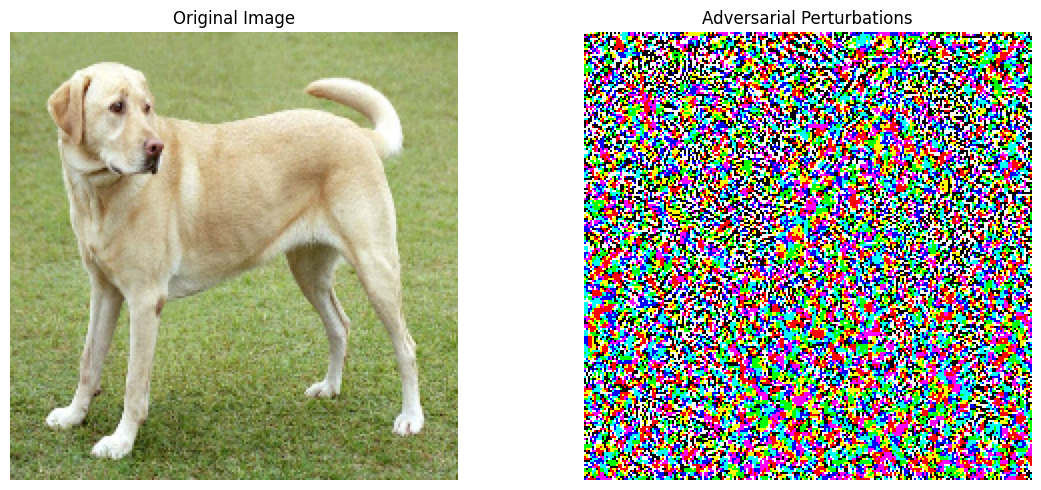


Generating adversarial examples with different epsilon values...
1/1 [==============================] - 0s 47ms/step


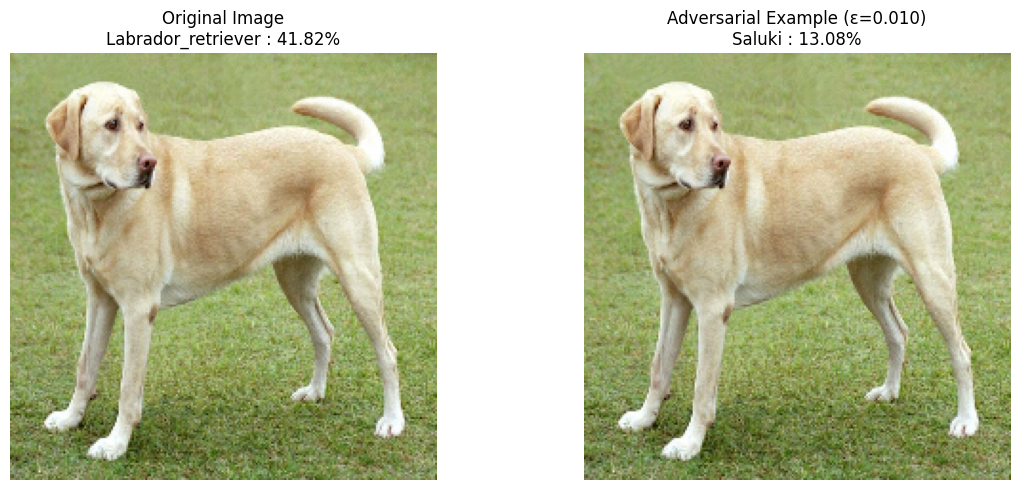

1/1 [==============================] - 0s 47ms/step


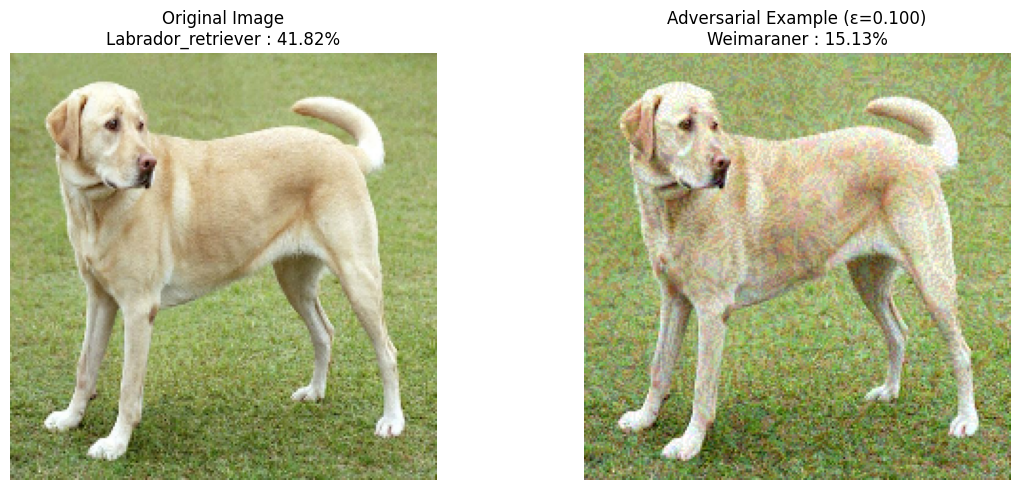

1/1 [==============================] - 0s 49ms/step


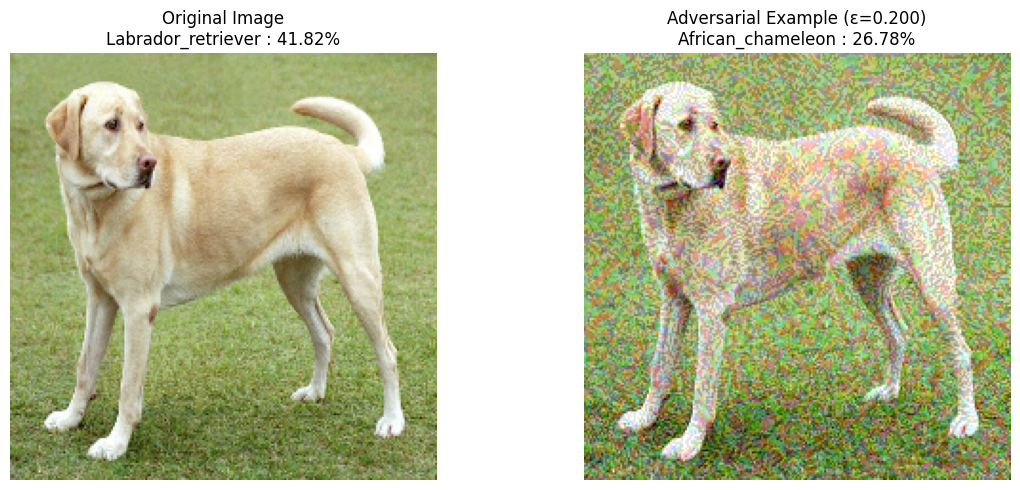

In [ ]:
target_class = 208  # Labrador retriever class index
run_adversarial_attack_demo(image, target_class)

## Extra Exercise Section
Try experimenting with:
1. Different epsilon values - how does this affect the attack's success and visibility?
2. Different input images - do some types of images work better than others?
3. Different target classes - can you modify the attack to target a specific class?

## Additional Notes:
- The epsilon value controls the strength of the attack. Larger values create stronger attacks but more visible perturbations.
- Some images may be more resistant to adversarial attacks than others.
- The success of the attack can vary depending on the confidence of the original prediction.